**Group Project Proposal: Pulsar Star Classification**

**Introduction**

Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal

Clearly state the question you will try to answer with your project

Identify and describe the dataset that will be used to answer the question

Preliminary exploratory data analysis:

Demonstrate that the dataset can be read from the web into R 

Clean and wrangle your data into a tidy format

Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 

Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

In [1]:
## install packages
#install.packages("tidyverse")


In [2]:
## load packages
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:


## LOADING DATA ##

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
#Create temporary file to store zip file and download zip file
temp <- tempfile()
download.file(url, temp)

#read dataset (HTRU_2.csv) from zip file (temp) + give each column appropriate name
pulsar_data <- read_csv(unz(temp, "HTRU_2.csv"), col_names = c("Mean integrated profile", 
                                                         "Standard deviation integrated profile", 
                                                         "Excess kurtosis integrated profile", 
                                                         "Skewness integrated profile",
                                                         "Mean DM-SNR curve",
                                                         "Standard deviation DM-SNR curve",
                                                         "Excess kurtosis DM-SNR curve",
                                                         "Skewness DM-SNR curve",
                                                         "Class"))
#delete temporary file (because no longer needed)
unlink(temp)


## CLEANING & WRANGLING DATA INTO A TIDY FORMAT ##

# make the class column (that determines whether an observation is a pulsar or not) as a factor
pulsar_data <- pulsar_data %>% 
        mutate(Class = as_factor(Class))

#replace spaces in column names by dots
colnames(pulsar_data) = make.names(colnames(pulsar_data))

## EXPLORATORY DATA ANALYSIS ##

# splitting data into training and testing data

pulsar_split <- initial_split(pulsar_data, prop = .75, strata = Class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

## summarize training data

# umber of observations in each class type
pulsar_train_summary <- pulsar_train %>% 
  group_by(Class) %>% 
  summarize( n = n())

pulsar_train_summary

# means of the predictor variables
pulsar_predictor_means <- pulsar_train %>% 
  select(-Class) %>% 
  summarize(across(everything(), mean))

pulsar_predictor_means

# number of rows with missing data

pulsar_missing_data <- pulsar_train %>% 
    filter_at(vars(all_of(colnames(pulsar_train))), any_vars(is.na(.)))

number_of_rows_missing <- nrow(pulsar_missing_data)
number_of_rows_missing  # there are no missing data in this dataset





Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Mean integrated profile, Standard deviation integrated profile, Exc...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Class,n
<fct>,<int>
0,12197
1,1226


Mean.integrated.profile,Standard.deviation.integrated.profile,Excess.kurtosis.integrated.profile,Skewness.integrated.profile,Mean.DM.SNR.curve,Standard.deviation.DM.SNR.curve,Excess.kurtosis.DM.SNR.curve,Skewness.DM.SNR.curve
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
111.0393,46.52411,0.4819599,1.800147,12.66369,26.35343,8.272635,103.9152


[1] 0

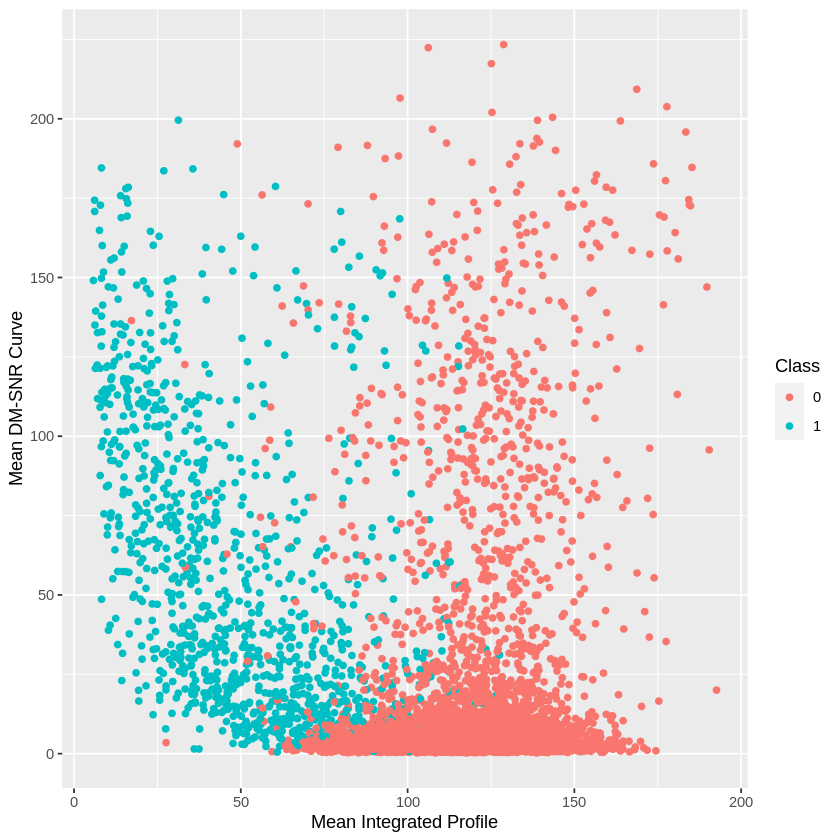

In [6]:
## EXPLORATORY DATA ANALYSIS: VISUALIZATIONS ##

## create a plot comparing the Mean Integrated Profile variable against the Mean DM-SNR Curve variable by Class
pulsar_plot1 <- pulsar_train %>% 
      ggplot(aes(x = Mean.integrated.profile, y = Mean.DM.SNR.curve, colour = Class))+
      geom_point()+
      labs( x = "Mean Integrated Profile" ,
            y =  "Mean DM-SNR Curve",
            colour = "Class" )

pulsar_plot1

**Methods**

Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?

Describe at least one way that you will visualize the results

**Expected outcomes and significance**

What do you expect to find?

What impact could such findings have?

What future questions could this lead to?